# My current 1x8 and 1x12 bass speaker designs

Francis Deck

Created: Long ago

Updated: Dec. 18, 2023

This notebook boils all of my design formulas down to a single Python function. It documents two of my designs. It's where I do my thinking.

* 12 inch ported system using Eminence 2512-ii driver. I've been quite happy with this design, it's a work horse, and I've been using it for well over a decade, both for electric and upright bass.

* **NEW!** 8 inch ported system using Faital Pro 8PR200, a high performance driver.

I decided to document and analyze both of my designs to serve as an example of using my formulas, plus to check the results carefully with the well known WinISD software.

## New instructions for use

* Download this notebook onto your hard drive.

* You can run Jupyter Lab in your browser with no software installation on your PC. Just surf to this link:

    https://jupyter.org/try-jupyter/lab/
    
* Click on "Upload Files"

    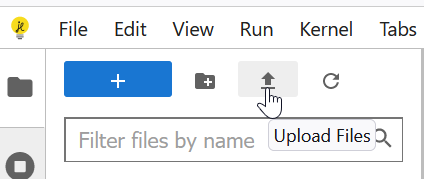
    
* Upload this notebook. It will appear in the list of files. Double-click on it. Now you're ready to go!

### License information

    The MIT License (MIT) Copyright (c) Francis Deck

    Permission is hereby granted, free of charge, to any person obtaining a copy of this 
    software and associated documentation files (the "Software"), to deal in the Software 
    without restriction, including without limitation the rights to use, copy, modify, 
    merge, publish, distribute, sublicense, and/or sell copies of the Software, and 
    to permit persons to whom the Software is furnished to do so, subject to the 
    following conditions:

    The above copyright notice and this permission notice shall be included in all 
    copies or substantial portions of the Software.

    THE SOFTWARE IS PROVIDED "AS IS", WITHOUT WARRANTY OF ANY KIND, EXPRESS OR IMPLIED, 
    INCLUDING BUT NOT LIMITED TO THE WARRANTIES OF MERCHANTABILITY, FITNESS FOR A 
    PARTICULAR PURPOSE AND NONINFRINGEMENT. IN NO EVENT SHALL THE AUTHORS OR COPYRIGHT 
    HOLDERS BE LIABLE FOR ANY CLAIM, DAMAGES OR OTHER LIABILITY, WHETHER IN AN ACTION 
    OF CONTRACT, TORT OR OTHERWISE, ARISING FROM, OUT OF OR IN CONNECTION WITH THE 
    SOFTWARE OR THE USE OR OTHER DEALINGS IN THE SOFTWARE.

In [1]:
from numpy import *
%matplotlib inline
from matplotlib.pyplot import *
import pandas as pd

In [25]:
# Physical constants

gamma = 1.4 # adiabatic constant, dimensionless
P_atm = 101325 # atmospheric pressure, Pa
rho = 1.18 # density of air, kg/m^3
c = sqrt(gamma*P_atm/rho) # https://en.wikipedia.org/wiki/Speed_of_sound
R = 1 # listening distance in meters

# TODO review whether this is the best set of parameters
f_min = 10
f_max = 1000
f = logspace(np.log10(f_min), np.log10(f_max), 300) # a range of frequencies from 10 to 1000 Hz
style = 'Francis' # preferred style is 'Francis', use 'WinISD to compare results with the WinISD software'
airspeed_units = 'm/s' # should be 'mach' or 'm/s'

def xCone(w = 2*pi*f, 
          F_s = 37, # free air resonance in Hz
          R_e= 5.04, # series resistance of voice coil in Ohms
          L_e = 0.46*0.001, # inductance of voice coil converted from mH to H
          Q_ms = 3.13, # mechanical contribution to Q factor
          Q_es = 0.44, # electromagnetic contribution to Q factor
          Vas = 147*0.001, # equivalent box volume, liters converted to m^3
          Xmax = 4.90*0.001, # maximum excursion, converted from mm to m
          S_d = 519.5/1e4, # cone area converted from cm^2 to m^2
          
          Znom = 8,
          Pin = 100, # input power used for calculations like cone excursion and port air speed
          V_box = 32*1e-3, # box volume, 32 l converted to m^3
          ported = True,
          f_port = 40, # port tuning frequency in Hz
          Q_port = 50,
          portShape = 'rectangular', # circular or rectangular
          d_port = 100*0.01, # diameter of port if circular in cm converted to m
          a_port = 3.5*0.01, # width of port if rectangular
          b_port = 21.5*0.01, # height of port if rectangular
          endCorrect = 0.732, # port end correction factor
          initReport = {},
          design = '',
         ):
    
    '''
    Compute cone excursion and other performance measures
    
    Parameters are self explanatory, all are in SI units
    '''
    
    w_0 = 2*pi*F_s # resonant frequency in radians/s
    m = gamma*P_atm*S_d**2/w_0**2/Vas # cone mass in kg
    BL = sqrt(w_0*m*R_e/Q_es) # BL product in T*m
    C = w_0*m/Q_ms # Mechanical damping constant of cone
    K = w_0**2*m # Spring constant of cone
    r = sqrt(S_d/pi) # Radius
    z = R_e + 1j*w*L_e # Electrical impedance
    if style == 'WinISD':
        Vin = sqrt(2*Pin*R_e) # Input voltage peak amplitude
    elif style == 'Francis':
        Vin = sqrt(2*Pin*Znom) # Input voltage peak amplitude
    else:
        print('style must be winISD or Francis')
    K_box = gamma*P_atm*S_d**2/V_box # Spring constant of box
        
    if ported:
        w_port = 2*pi*f_port # port resonant frequency in radians/s
        kappa = w**2/(w**2 - 1j*w*w_port/Q_port - w_port**2) # correction factor for box spring constant based on port behavior
    else:
        kappa = 1 # i.e., no port therefore no port correction

    Keff = K + kappa*K_box # total spring constant, from driver suspension plus port-corrected box
    
    x = BL*Vin/m/z/(Keff/m + 1j*w*(BL**2/m/z + C/m) - w**2) # cone excursion amplitude in meters

    Z = z/(1 - 1j*w*BL*x/Vin) # cone impedance, complex valued, in Ohms

    p = rho*r**2*w**2*kappa*x/R/2 # sound pressure amplitude in Pascal
    p_rms = p/sqrt(2)

    p_ref = 20e-6 # reference value for sound pressure, in Pascal
    spl = 20*log10(abs(p_rms)/p_ref) # sound pressure level in dB SPL
    
    phaseRot = 180*pi/180 # phase rotation for phase graph, to make it agree with WinISD
    phase = angle(p*(cos(phaseRot) + 1j*sin(phaseRot)))*180/pi # phase of acoustic wavefront, nearfield
     
    # More ported behavior
    
    if ported:
        kappa2 = w_port**2/(w**2 - 1j*w*w_port/Q_port - w_port**2)
        
        if portShape == 'circular':
            S_port = pi*d_port**2/4
            Rport = d_port/2
        elif portShape == 'rectangular': 
            S_port = a_port*b_port
            Rport = min(a_port, b_port)/2 # assume effective radius is the smaller of the two dimensions
            initReport['d_port'] = sqrt(4*S_port/pi)
        else:
            print('portShape needs to be circular or rectangular')
        
        if airspeed_units == 'mach':
            v_port = 1j*w*kappa2*x*S_d/S_port/c # speed of port air plug
        elif airspeed_units == 'm/s':
            v_port = 1j*w*kappa2*x*S_d/S_port # speed of port air plug
        else:
            print('Airspeed units must be mach or m/s')
        
        lport = S_port*gamma*P_atm/rho/V_box/w_port**2 - Rport*2*endCorrect # length of port in meters
        
    else:
        v_port = None
        
    Q_ts = 1/(1/Q_ms + 1/Q_es)
    Q_tc = Q_ts*sqrt(1 + Vas/V_box)
        
    report = dict(initReport)
    report['resonant angular frequency w_0 (1/s)'] = w_0
    report['cone mass m (kg)'] = m
    report['magnetic field length product BL (T m)'] = BL
    report['mechanical damping factor (N/(m/s))'] = C
    report['mechanical spring constant (N/m)'] = K
    report['mechanical compliance (m/N)'] = 1/K
    report['input power (W)'] = Pin
    report['peak input voltage (V)'] = Vin
    report['cone radius (m)'] = r
    report['box spring constant (N/m)'] = K_box
    report['Port angular frequency (1/s)'] = w_port
    report['Port area (m^2)'] = S_port
    report['Port effective radius (m)'] = Rport
    report['Length of port (m)'] = lport
    report['Length of port (in)'] = lport*39.3
    report['Volume of port (l)'] = lport*S_port*1000
    report['Total driver Q'] = Q_ts
    report['Total system Q'] = Q_tc
        
    return x, Z, spl, phase, v_port, p, pd.DataFrame([[tag, report[tag]] for tag in report])

def graphs(f, x, Z, spl, phase, v_port, label):
    ax[0].semilogx(f, abs(x)*1000, label = label)
    ax[0].set_ylabel('cone excursion amplitude (mm)')
    
    ax[1].semilogx(f, abs(Z), label = label)
    ax[1].set_ylabel('impedance ($\Omega$)')

    ax[2].semilogx(f, spl, label = label)
    ax[2].set_ylabel('Sound pressure (dB SPL)')

    ax[3].semilogx(f, phase, label = label)
    ax[3].set_ylabel('Phase')

    ax[4].semilogx(f, abs(v_port), label = label)
    ax[4].set_xlabel('frequency (Hz)')
    ax[4].set_ylabel('port air speed (' + airspeed_units + ')')
        
    
    for a in ax:
        a.set_xticks([10, 20, 40, 60, 100, 200, 400, 600])
        a.get_xaxis().set_major_formatter(matplotlib.ticker.ScalarFormatter())
        a.legend()
    
def runGraph(name, driver, box):
    x, Z, spl, phase, v_port, p1, df = xCone(**(name | driver | box), initReport = name | driver | box) 
    label = name['design']
    graphs(f, x, Z, spl, phase, v_port, label)
    return df

In [29]:
# Driver library.

emi2512ii = { # Eminence DeltaLite 2512-ii
    'F_s': 37, # resonant frequency in Hz
    'R_e': 5.04, # series resistance of voice coil in Ohms
    'L_e': 0.46*0.001, # inductance of voice coil converted from mH to H
    'Q_ms': 3.13, # mechanical contribution to Q factor
    'Q_es': 0.44, # electromagnetic contribution to Q factor
    'Vas': 147*0.001, # equivalent box volume, liters converted to m^3
    'Xmax': 4.90*0.001, # maximum excursion, converted from mm to m
    'S_d': 519.5/1e4, # cone area converted from cm^2 to m^2
}

emi2512ii_2024 = { # Eminence DeltaLite 2512-ii, new datasheet in 2024
    'F_s': 53.1, # resonant frequency in Hz
    'R_e': 5.28, # series resistance of voice coil in Ohms
    'L_e': 0.31*0.001, # inductance of voice coil converted from mH to H
    'Q_ms': 2.94, # mechanical contribution to Q factor
    'Q_es': 0.64, # electromagnetic contribution to Q factor
    'Vas': 64.44*0.001, # equivalent box volume, liters converted to m^3
    'Xmax': 4.90*0.001, # maximum excursion, converted from mm to m
    'S_d': 519.5/1e4, # cone area converted from cm^2 to m^2
}

fp8pr200 = { # Faital Pro 8PR200
    'F_s': 58, # resonant frequency in Hz
    'R_e': 5.1, # series resistance of voice coil in Ohms
    'L_e': 0.55*0.001, # inductance of voice coil converted from mH to H
    'Q_ms': 9.4, # mechanical contribution to Q factor
    'Q_es': 0.38, # electromagnetic contribution to Q factor
    'Vas': 16.9*0.001, # equivalent box volume, liters converted to m^3
    'Xmax': 8.15*0.001, # maximum excursion, converted from mm to m
    'S_d': 209/1e4, # cone area converted from cm^2 to m^2
}

emi2510ii = { # Eminence DeltaLite II 2510
    'F_s': 53, # resonant frequency in Hz
    'R_e': 5.06, # series resistance of voice coil in Ohms
    'L_e': 4*0.001, # inductance of voice coil converted from mH to H
    'Q_ms': 5.76, # mechanical contribution to Q factor
    'Q_es': 0.45, # electromagnetic contribution to Q factor
    'Vas': 52.5*0.001, # equivalent box volume, liters converted to m^3
    'Xmax': 4.2*0.001, # maximum excursion, converted from mm to m
    'S_d': 350.1/1e4, # cone area converted from cm^2 to m^2
}

# Box database

box1 = { # My little 12" box
    'Znom': 8,
    'Pin': 100,
    'V_box': 32*1e-3, # box volume, 32 l converted to m^3
    'ported': True,
    'f_port': 40, # port tuning frequency in Hz
    'Q_port': 50, # value borrowed from WinISD
    'portShape': 'rectangular', # circular or rectangular
    'd_port': None, # diameter of port if circular in cm converted to m
    'a_port': 3.5*0.01, # width of port if rectangular
    'b_port': 21.5*0.01, # height of port if rectangular
    'endCorrect': 0.732, # port end correction factor
}

box2 = { # My little 8" box as designed
    'Znom': 8,
    'Pin': 100,
    'V_box': 15*1e-3, # box volume, 32 l converted to m^3
    'ported': True,
    'f_port': 40, # port tuning frequency in Hz
    'Q_port': 20, # value borrowed from WinISD
    'portShape': 'rectangular', # circular or rectangular
    'd_port': None, # diameter of port if circular in cm converted to m
    'a_port': 5.5*0.01, # width of port if rectangular
    'b_port': 5.5*0.01, # height of port if rectangular
    'endCorrect': 0.732, # port end correction factor
}

box3 = {
    'Znom': 8,
    'Pin': 100,
    'V_box': 15*1e-3, # box volume, 32 l converted to m^3
    'ported': True,
    'f_port': 45, # port tuning frequency in Hz
    'Q_port': 20, # value borrowed from WinISD
    'portShape': 'rectangular', # circular or rectangular
    'd_port': None, # diameter of port if circular in cm converted to m
    'a_port': 5.5*0.01, # width of port if rectangular
    'b_port': 5.5*0.01, # height of port if rectangular
    'endCorrect': 0.732, # port end correction factor
}

box4 = {
    'Znom': 8,
    'Pin': 100,
    'V_box': 15*1e-3, # box volume, 32 l converted to m^3
    'ported': True,
    'f_port': 50, # port tuning frequency in Hz
    'Q_port': 10, # value borrowed from WinISD
    'portShape': 'circular', # circular or rectangular
    'd_port': 7.62*0.01, # diameter of port if circular in cm converted to m
    'a_port': 7*0.01, # width of port if rectangular
    'b_port': 7*0.01, # height of port if rectangular
    'endCorrect': 0.732, # port end correction factor
}

box5 = {
    'Znom': 8,
    'Pin': 100,
    'V_box': 23*1e-3, # box volume, 32 l converted to m^3
    'ported': True,
    'f_port': 55, # port tuning frequency in Hz
    'Q_port': 10, # value borrowed from WinISD
    'portShape': 'rectangular', # circular or rectangular
    'd_port': 7.62*0.01, # diameter of port if circular in cm converted to m
    'a_port': 4.5*0.01, # width of port if rectangular
    'b_port': 9*0.01, # height of port if rectangular
    'endCorrect': 0.732, # port end correction factor
}

In [27]:
'''
Data harvested from the Javascript version of my program, to test whether it agrees with this program
'''

jsData = '''f(hz), x(mm), v(mach)
20, 21.336504357769137, 0.07153718094165383
21, 19.073209639647633, 0.06952154973709046
22, 16.965420576876454, 0.067279525546725
23, 15.03113337050393, 0.0649366525243461
24, 13.273305735063357, 0.06258210784022133
25, 11.685427958252502, 0.0602753608206378
26, 10.255739781898304, 0.05805346861020408
27, 8.970105704756303, 0.055937489813107956
28, 7.813820726635035, 0.05393753800801991
29, 6.772656462182154, 0.05205651286857316
30, 5.833407000201076, 0.05029273996126989
31, 4.98412403084556, 0.04864178239414374
32, 4.214169310507023, 0.047097654396971396
33, 3.514166568655125, 0.04565361648228716
34, 2.8759033668818077, 0.0443026841789255
35, 2.2922128058656357, 0.043037943854451186
36, 1.7568520050819694, 0.041852740372878575
37, 1.2643863526036385, 0.04074078073115541
38, 0.8100838089553417, 0.039696183444435595
39, 0.3898208332146036, 0.03871349358647336
40, 0.000005979161221369143, 0.03778766238663786
41, 0.3625213976902098, 0.03691410023435766
42, 0.7004928150516936, 0.03608850829317266
43, 1.0163231573086617, 0.03530699314980293
44, 1.3121258637192277, 0.03456596602600739
45, 1.5897574370617913, 0.033862128436891785
46, 1.8508503710221418, 0.03319244497440433
47, 2.0968413105541632, 0.03255411797897349
48, 2.32899516749984, 0.03194456431108409
49, 2.5484258108060787, 0.031361394281693065
50, 2.7561138595719736, 0.0308023927071896
51, 2.9529220281056623, 0.03026550200051776
52, 3.1396084044372468, 0.029748807181277852
53, 3.316837986168599, 0.029250522674826012
54, 3.485192748843695, 0.02876898076737818
55, 3.6451804809068937, 0.02830262158674425
56, 3.7972425845821673, 0.02784998448380834
57, 3.941761012577093, 0.02740970069642266
58, 4.0790644854471365, 0.02698048718382675
59, 4.20943411293469, 0.026561141525323368
60, 4.3331085239315685, 0.026150537781330623
61, 4.450288593324547, 0.02574762321791107
62, 4.561141839395593, 0.02535141579744548
63, 4.665806552281646, 0.024961002338402167
64, 4.764395701961465, 0.024575537246388442
65, 4.8570006631199005, 0.024194241717188227
66, 4.943694783910388, 0.023816403310687663
67, 5.024536816033074, 0.023441375792924095
68, 5.0995742146706196, 0.023068579142447983
69, 5.16884630873414, 0.02269749961725641
70, 5.232387334669111, 0.022327689780212302
71, 5.2902293208880815, 0.021958768384520735
72, 5.342404804881381, 0.02159042002682327
73, 5.38894936135426, 0.02122239448399996
74, 5.429903917475027, 0.02085450566090073
75, 5.465316830581316, 0.020486630089854307
76, 5.495245704515424, 0.020118704938647494
77, 5.519758923113347, 0.01975072550127313
78, 5.538936883152252, 0.019382742164512076
79, 5.552872914089626, 0.019014856862615056
80, 5.561673877957788, 0.01864721905118741
81, 5.56546044950672, 0.018280021249032462
82, 5.5643670837729475, 0.017913494212393705
83, 5.558541685331204, 0.01754790181905955
84, 5.5481450002025, 0.017183535749607837
85, 5.533349757418995, 0.016820710059299332
86, 5.514339592304055, 0.01645975573661391
87, 5.491307787401882, 0.016101015343199406
88, 5.464455869549122, 0.015744837825313582
89, 5.4339921027655445, 0.015391573579094554
90, 5.400129916476057, 0.015041569841743242
91, 5.363086307157162, 0.014695166468580115
92, 5.32308024898114, 0.014352692142627507
93, 5.280331145607702, 0.014014461049543788
94, 5.235057351169066, 0.013680770037027487
95, 5.187474783942964, 0.013351896264770883
96, 5.137795651436355, 0.013028095339125008
97, 5.086227300819816, 0.012709599916182068
98, 5.032971204039897, 0.012396618748206812
99, 4.978222082642061, 0.012089336141368482
100, 4.92216717347176, 0.011787911787551198
101, 4.864985633059894, 0.011492480929579371
102, 4.806848075682983, 0.011203154817352639
103, 4.747916237827804, 0.010920021411955413
104, 4.688342760070902, 0.010643146295580913
105, 4.628271076171612, 0.010372573746864566
106, 4.5678353984244815, 0.010108327943733973
107, 4.507160787966997, 0.009850414258943388
108, 4.446363298729491, 0.009598820616876842
109, 4.3855501839842175, 0.00935351888380921
110, 4.324820154939828, 0.009114466267466585
111, 4.2642636814803, 0.008881606705312104
112, 4.203963325913902, 0.00865487222441158
113, 4.143994101434708, 0.008434184258940313
114, 4.08442384786968, 0.008219454914333289
115, 4.025313618158927, 0.008010588169730406
116, 3.9667180698713587, 0.007807481012714495
117, 3.9086858568749827, 0.007610024502383177
118, 3.8512600170477342, 0.007418104758546677
119, 3.7944783526220474, 0.007231603876317365
120, 3.738373800400076, 0.0070504007665752435
121, 3.682974789653878, 0.006874371923779248
122, 3.6283055860367392, 0.006703392123372423
123, 3.574386620279809, 0.006537335051624356
124, 3.521234800835816, 0.006376073871191233
125, 3.4688638099626594, 0.006219481725975108
126, 3.4172843830190898, 0.006067432189051164
127, 3.366504570976984, 0.005919799657524138
128, 3.316529986345122, 0.005776459698189815
129, 3.267364032852575, 0.005637289347830687
130, 3.2190081193603635, 0.005502167371878879
131, 3.1714618585624956, 0.005370974485046915
132, 3.1247232511056136, 0.00524359353736682
133, 3.0787888558039804, 0.005119909668899081
134, 3.0336539466568886, 0.004999810436182027
135, 2.9893126573913236, 0.004883185913294496
136, 2.9457581142568077, 0.004769928770205105
137, 2.902982557793825, 0.004659934330883526
138, 2.8609774542840514, 0.004553100613455414
139, 2.8197335975715743, 0.004449328354495565
140, 2.779241201920641, 0.004348521019374669
141, 2.739489986548613, 0.004250584800404937
142, 2.7004692524435274, 0.004155428604369486
143, 2.662167952045038, 0.004062964030870119
144, 2.6245747523359944, 0.003973105342788122
145, 2.5876780918602544, 0.0038857694300228045
146, 2.5514662321508257, 0.003800875767552592
147, 2.5159273040215355, 0.003718346368753137
148, 2.4810493491453713, 0.0036381057348058407
149, 2.4468203573135603, 0.003560080800937666
150, 2.4132282997417, 0.0034842008801491187
151, 2.38026115876262, 0.0034103976050106296
152, 2.347906954220534, 0.003338604868038473
153, 2.3161537668571817, 0.003268758761098603
154, 2.284989758958277, 0.0032007975142304404
155, 2.2544031925075334, 0.003134661434231823
156, 2.224382445075843, 0.0030702928433007687
157, 2.1949160236548453, 0.0030076360179888623
158, 2.1659925766269685, 0.002946637128684622
159, 2.1376009040481936, 0.0028872441798126597
160, 2.109729966404986, 0.0028294069509054815
161, 2.082368891993251, 0.0027730769386791255
162, 2.0555069830545034, 0.0027182073002209976
163, 2.029133720792828, 0.0026647527973782136
164, 2.0032387693854616, 0.0026126697424169857
165, 1.9778119790899236, 0.0025619159450079856
166, 1.9528433885415524, 0.0025124506605790015
167, 1.928323226326935, 0.002464234540064229
168, 1.90424191191103, 0.002417229581069089
169, 1.88059005598878, 0.002371399080460564
170, 1.8573584603255169, 0.002326707588385096
171, 1.8345381171445958, 0.0022831208637095124
172, 1.812120208115245, 0.0022406058308746184
173, 1.790096102988714, 0.002199130538146287
174, 1.7684573579262393, 0.0021586641172447307
175, 1.7471957135582556, 0.0021191767443292085
176, 1.7263030928104817, 0.002080639602312618
177, 1.7057715985290849, 0.0020430248444780427
178, 1.6855935109339788, 0.0020063055593675335
179, 1.6657612849264611, 0.0019704557369119133
180, 1.646267547274781, 0.001935450235769304
181, 1.6271050936988545, 0.001901264751839291
182, 1.6082668858731994, 0.001867875787919113
183, 1.589746048365172, 0.0018352606244679598
184, 1.5715358655238214, 0.0018033972914453878
185, 1.5536297783330524, 0.0017722645411899238
186, 1.5360213812412948, 0.0017418418223041597
187, 1.5187044189785674, 0.001712109254512989
188, 1.5016727833705823, 0.0016830476044620815
189, 1.4849205101584495, 0.001654638262424234
190, 1.4684417758315482, 0.0016268632198818559
191, 1.4522308944802103, 0.0015997050479545105
192, 1.4362823146740515, 0.0015731468766411324
193, 1.4205906163710678, 0.0015471723748473438
194, 1.405150507861896, 0.001521765731169014
195, 1.3899568227530934, 0.0014969116354040548
196, 1.3750045169927, 0.001472595260765236
197, 1.3602886659408826, 0.0014488022467676383
198, 1.34580446148801, 0.0014255186827651764
199, 1.3315472092221141, 0.0014027310921114631
200, 1.3175123256473238, 0.0013804264169210757
201, 1.303695335454567, 0.001358592003408148
202, 1.2900918688455116, 0.0013372155877799379
203, 1.2766976589104924, 0.0013162852826638684
204, 1.263508539060929, 0.0012957895640472845
205, 1.250520440516531, 0.0012757172587099098
206, 1.237729389847416, 0.001256057532129746
207, 1.2251315065711084, 0.0012367998768438673
208, 1.2127230008042247, 0.0012179341012462487
209, 1.200500170968556, 0.0011994503188054672
210, 1.1884594015511178, 0.0011813389376857453
211, 1.1765971609176704, 0.0011635906507554742
212, 1.1649099991791114, 0.0011461964259679527
213, 1.1533945461100652, 0.0011291474970996666
214, 1.1420475091189584, 0.001112435354832045
215, 1.130865671268789, 0.0010960517381631463
216, 1.1198458893477639, 0.0010799886261362909
217, 1.10898509198895, 0.0010642382298731692
218, 1.098280277838039, 0.001048792984899447
219, 1.087728513768308, 0.001033645543751375
220, 1.0773269331418485, 0.0010187887688523827
221, 1.067072734116096, 0.0010042157256490516
222, 1.0569631779947146, 0.000989919675996335
223, 1.04699558762186, 0.0009758940717822566
224, 1.037167345818851, 0.0009621325487827549
225, 1.0274758938622792, 0.0009486289207376877
226, 1.0179187300025898, 0.0009353771736394029
227, 1.008493408022168, 0.0009223714602256125
228, 0.9991975358319737, 0.0009096060946686491
229, 0.9900287741057793, 0.0008970755474535086
230, 0.9809848349510734, 0.0008847744404373922
231, 0.9720634806157024, 0.0008726975420837477
232, 0.9632625222293363, 0.0008608397628641093
233, 0.9545798185788663, 0.0008491961508212943
234, 0.9460132749168437, 0.0008377618872877912
235, 0.9375608418020929, 0.0008265322827534018
236, 0.9292205139716467, 0.0008155027728764647
237, 0.9209903292431707, 0.0008046689146332062
238, 0.9128683674470499, 0.0007940263825999783
239, 0.9048527493873438, 0.000783570965363369
240, 0.8969416358308155, 0.0007732985620533654
241, 0.8891332265232817, 0.0007632051789949423
242, 0.8814257592325175, 0.0007532869264736414
243, 0.8738175088169945, 0.0007435400156108764
244, 0.8663067863197329, 0.0007339607553448758
245, 0.8588919380865744, 0.0007245455495133442
246, 0.851571344908187, 0.0007152908940340585
247, 0.8443434211851516, 0.0007061933741797985
248, 0.837206614115471, 0.000697249661944118
249, 0.8301594029038802, 0.0006884565134946354
250, 0.8232002979923447, 0.0006798107667106299'''
fjs, xjs, sjs = array([list(map(float, s.split(','))) for s in jsData.split('\n')[1:]]).transpose()

,0,1,2,3,4
0,design,1x12 ported,1x12 ported,1x8 design,1x8 as built
1,F_s,37,53.1,58,58
2,R_e,5.04,5.28,5.1,5.1
3,L_e,0.00046,0.00031,0.00055,0.00055
4,Q_ms,3.13,2.94,9.4,9.4
5,Q_es,0.44,0.64,0.38,0.38
6,Vas,0.147,0.06444,0.0169,0.0169
7,Xmax,0.0049,0.0049,0.00815,0.00815
8,S_d,0.05195,0.05195,0.0209,0.0209
9,Znom,8,8,8,8


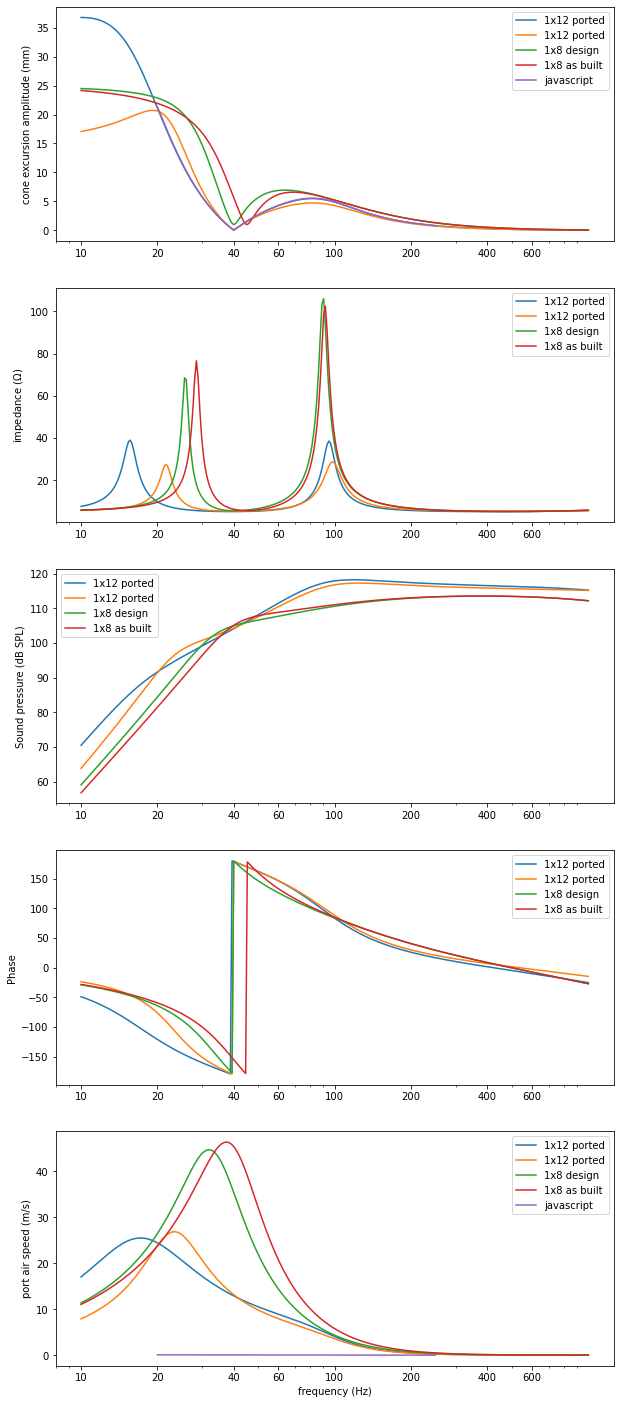

In [34]:
fig, ax = subplots(5, 1, figsize = (10, 25))

df1 = runGraph({'design': '1x12 ported'}, emi2512ii, box1)
df1a = runGraph({'design': '1x12 ported'}, emi2512ii_2024, box1)

df2 = runGraph({'design': '1x8 design'}, fp8pr200, box2)
df3 = runGraph({'design': '1x8 as built'}, fp8pr200, box3)
#df4 = runGraph({'design': 'proposed'}, fp8pr200, box4)

df1[2] = df1a[1]
df1[3] = df2[1]
df1[4] = df3[1]
#df1[5] = df4[1]
display(df1)

ax[0].plot(fjs, xjs, label = 'javascript')
ax[0].legend()
ax[4].plot(fjs, sjs, label = 'javascript')
ax[4].legend()
show()

# Measured curves for 12" box

## Impedance

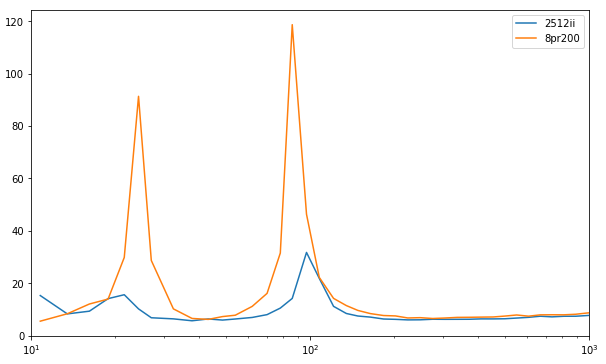

## Nearfield cone response

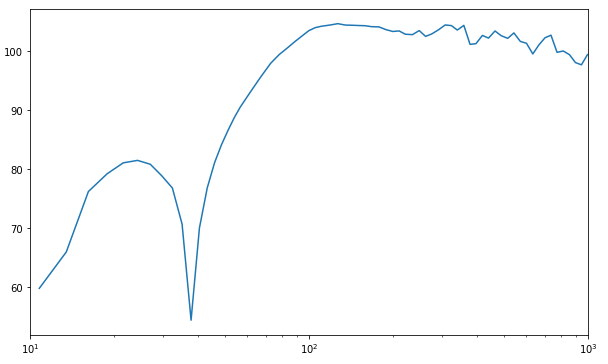

# Graphs for these designs from WinISD

There's a disagreement between me and WinISD, as to how we calculate the signal in Volts feeding the speaker, see above
for the "style" parameter. WinISD uses the $R_e$ of the coil, I use the nominal impedance. I've set the "style" to WinISD
for the purpose of comparison.

### Excursion amplitude
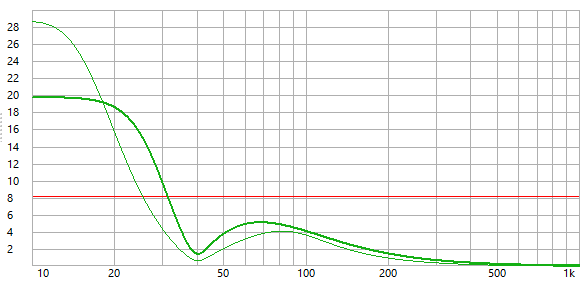

### Impedance
I get the same peak frequencies as WinISD, but noticeably different peak heights

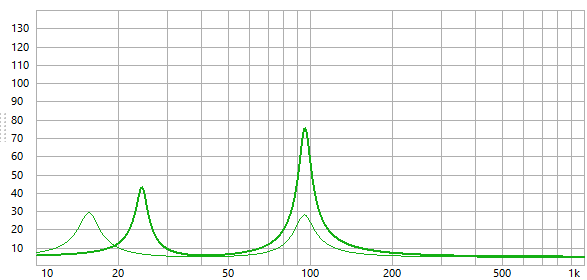

### SPL
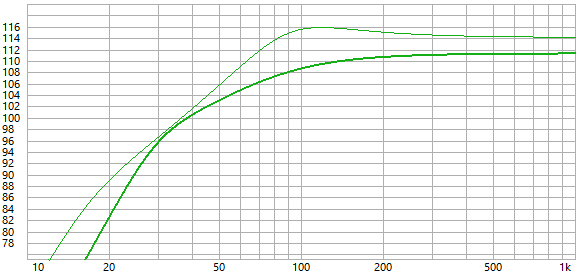

### Phase

I added a 180$^{\circ}$ phase rotation to make my graph match WinISD. This shouldn't have an acoustic effect, but is useful for comparing the programs.

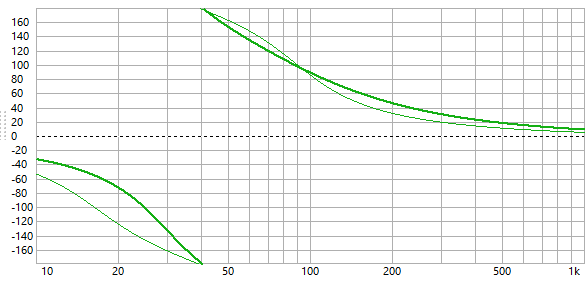

### Port air speed
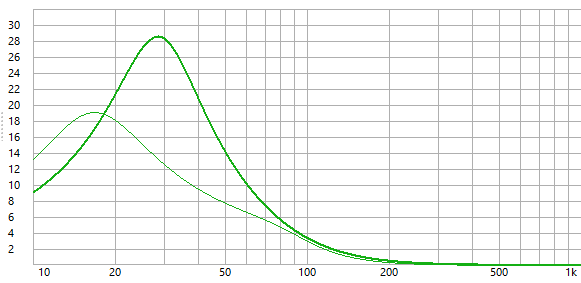

In [1]:
# don't forget to save before running this cell...
!jupyter nbconvert --to html "12 and 8 inch designs.ipynb"

[NbConvertApp] Converting notebook 12 and 8 inch designs.ipynb to html
[NbConvertApp] Writing 936639 bytes to 12 and 8 inch designs.html


In [12]:
4.35+0.375

4.725